# Detect Fake Human Face AI Genearted Image


## About The Data

* The "fake" images are generated using state-of-the-art generative models including StyleGAN3, DALL·E 3, Midjourney, and Stable Diffusion 3
* The "real" images are sourced from publicly available datasets and photographic repositories

------------------------------------------------------------------------------------------------

# Phase 1: Data Exploration & Preparation

## Visual inspection of random samples

## Create Train/Validation Split

In [65]:

import os
import random
import torch.nn.parallel
import torch.utils.data
import yaml

from dataset.DeepfakeDataset import AbstractDataset
from logger import create_logger
from optimizor.SAM import SAM
from prepare_data import load_train


def prepare_train_data(config, logger):
    train_files, val_files, test_files = load_train(config, logger)
    print(len(train_files["real"]), len(train_files["fake"]), len(val_files["real"]), len(val_files["fake"]), len(test_files["real"]), len(test_files["fake"]))
    train_data_loader = torch.utils.data.DataLoader(
        dataset=AbstractDataset(train_files, config, mode='train'),
        batch_size=config["dataset"]["train"]['batch_size'],
        shuffle=True,
        num_workers=int(config["dataset"]["train"]['workers'])
    )
    val_data_loader = torch.utils.data.DataLoader(
        dataset=AbstractDataset(val_files, config, mode='val'),
        batch_size=config["dataset"]["train"]['batch_size'],
        shuffle=False,
        num_workers=int(config["dataset"]["train"]['workers'])
    )
    test_data_loader = torch.utils.data.DataLoader(
        dataset=AbstractDataset(test_files, config, mode='test'),
        batch_size=config["dataset"]["train"]['batch_size'],
        shuffle=False,
        num_workers=int(config["dataset"]["train"]['workers'])
    )
    return train_data_loader, val_data_loader, test_data_loader

with open("config/run_resnet50.yaml", 'r') as f:
    config = yaml.safe_load(f)
config["dataset"] = {}

for train_dataset_config_path in config["train_dataset_configs"]:
    with open(train_dataset_config_path, 'r') as f:
        config["dataset"]["train"] = config["dataset"]["test"] = yaml.safe_load(f)

logger = create_logger("/log/tmp.log")
train_dataset, val_dataset, test_dataset = prepare_train_data(config, logger)

2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29621/4224/8563
2026-01-09 21:36:55,724 - INFO - FaceForensics++ real images: 29

JSON文件已存在: ../dataset/FaceForensics++/label.json
JSON文件已存在: ../dataset/deepfacelab/label.json
JSON文件已存在: ../dataset/deepfacelab/label.json
JSON文件已存在: ../dataset/StyleGAN2/label.json
JSON文件已存在: ../dataset/fsgan/label.json
JSON文件已存在: ../dataset/faceswap/label.json
30694 58552 4383 8394 8879 16747


# Phase 2 : Data Transformation

In [66]:
# Define transforms for train/val/test

from torchvision import transforms

# Training transforms (WITH augmentation)
train_transforms = transforms.Compose([])

# Validation/Test transforms (NO augmentation)
val_transforms = transforms.Compose([
])

print("✅ Transforms defined:")
print(f"\nTrain transforms (with augmentation):")
print(train_transforms)
print(f"\nValidation/Test transforms (no augmentation):")
print(val_transforms)

✅ Transforms defined:

Train transforms (with augmentation):
Compose(
)

Validation/Test transforms (no augmentation):
Compose(
)


## Data Loader
Batch size is 16

In [67]:
# Create PyTorch DataLoaders

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from pathlib import Path

# Paths
work_data = Path(r"/root/autodl-tmp/tmp/workdata")

# Batch size (how many images processed at once)
BATCH_SIZE = 128  # Adjust based on GPU memory (32 is safe for most GPUs)

# Number of workers (parallel image loading)
NUM_WORKERS = 4  # Use 4 CPU cores for loading (speeds up training)


train_loader = train_dataset

val_loader = val_dataset

test_loader = test_dataset

print(f"\n✅ DataLoaders created:")
print(f"  - Train batches: {len(train_loader):,} (each with {BATCH_SIZE} images)")
print(f"  - Val batches:   {len(val_loader):,}")
print(f"  - Test batches:  {len(test_loader):,}")

# Verify by loading one batch
print(f"\n{'='*60}")
print("VERIFICATION: Loading one batch...")
print(f"{'='*60}")

images, labels = next(iter(train_loader))
print(f"✅ Batch loaded successfully!")
print(f"  - Image tensor shape: {images.shape}  (batch_size, channels, height, width)")
print(f"  - Labels shape: {labels.shape}")
print(f"  - Labels in this batch: {labels.tolist()[:10]}... (0=fake, 1=real)")
print(f"  - Image value range: [{images.min():.2f}, {images.max():.2f}] (normalized)")


✅ DataLoaders created:
  - Train batches: 698 (each with 128 images)
  - Val batches:   100
  - Test batches:  201

VERIFICATION: Loading one batch...
✅ Batch loaded successfully!
  - Image tensor shape: torch.Size([128, 3, 224, 224])  (batch_size, channels, height, width)
  - Labels shape: torch.Size([128])
  - Labels in this batch: [0, 1, 0, 1, 1, 1, 0, 1, 1, 1]... (0=fake, 1=real)
  - Image value range: [-1.00, 1.00] (normalized)


## Visualize Transformed Images

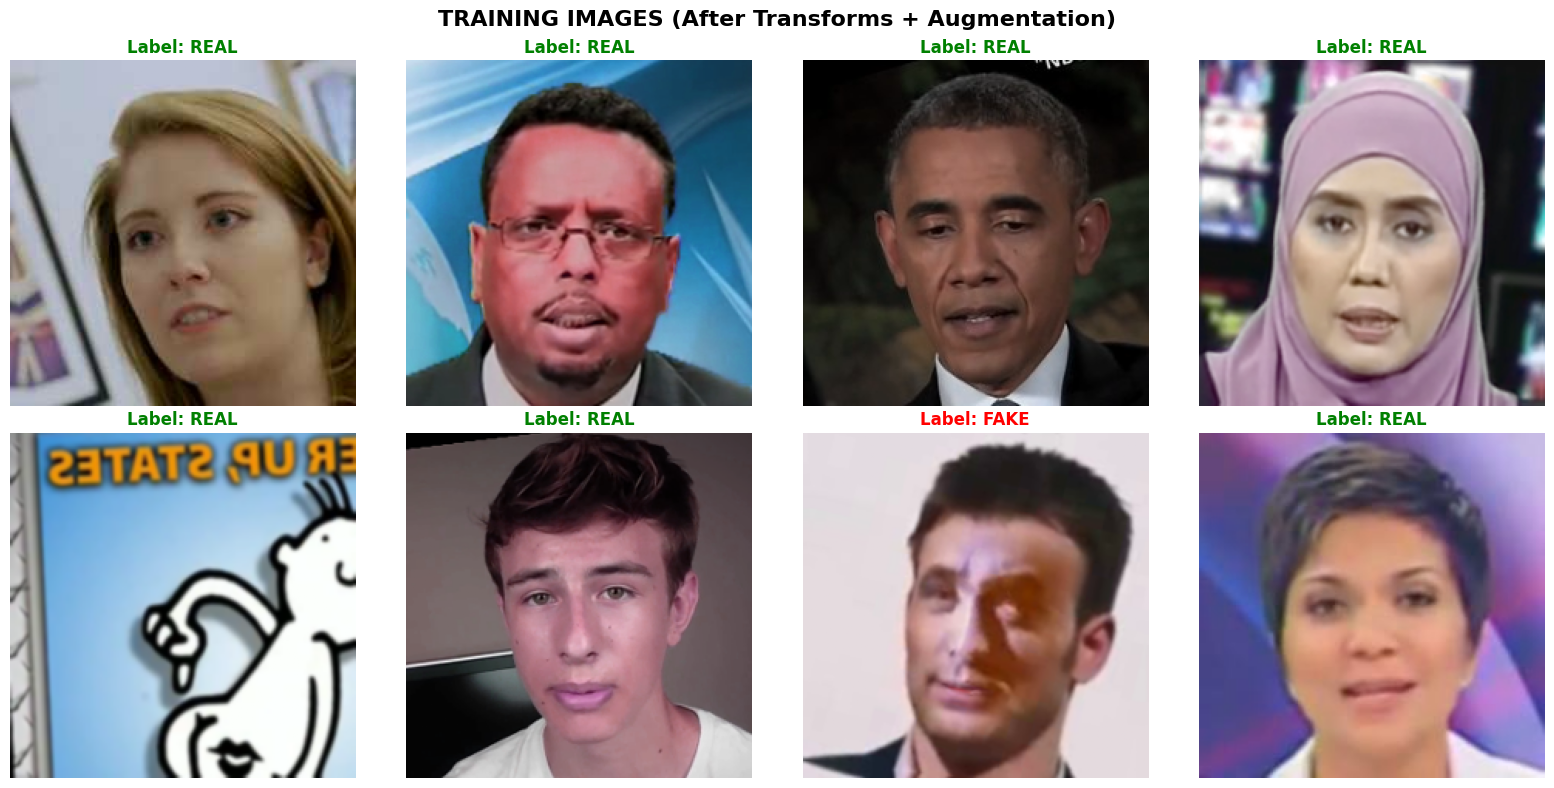

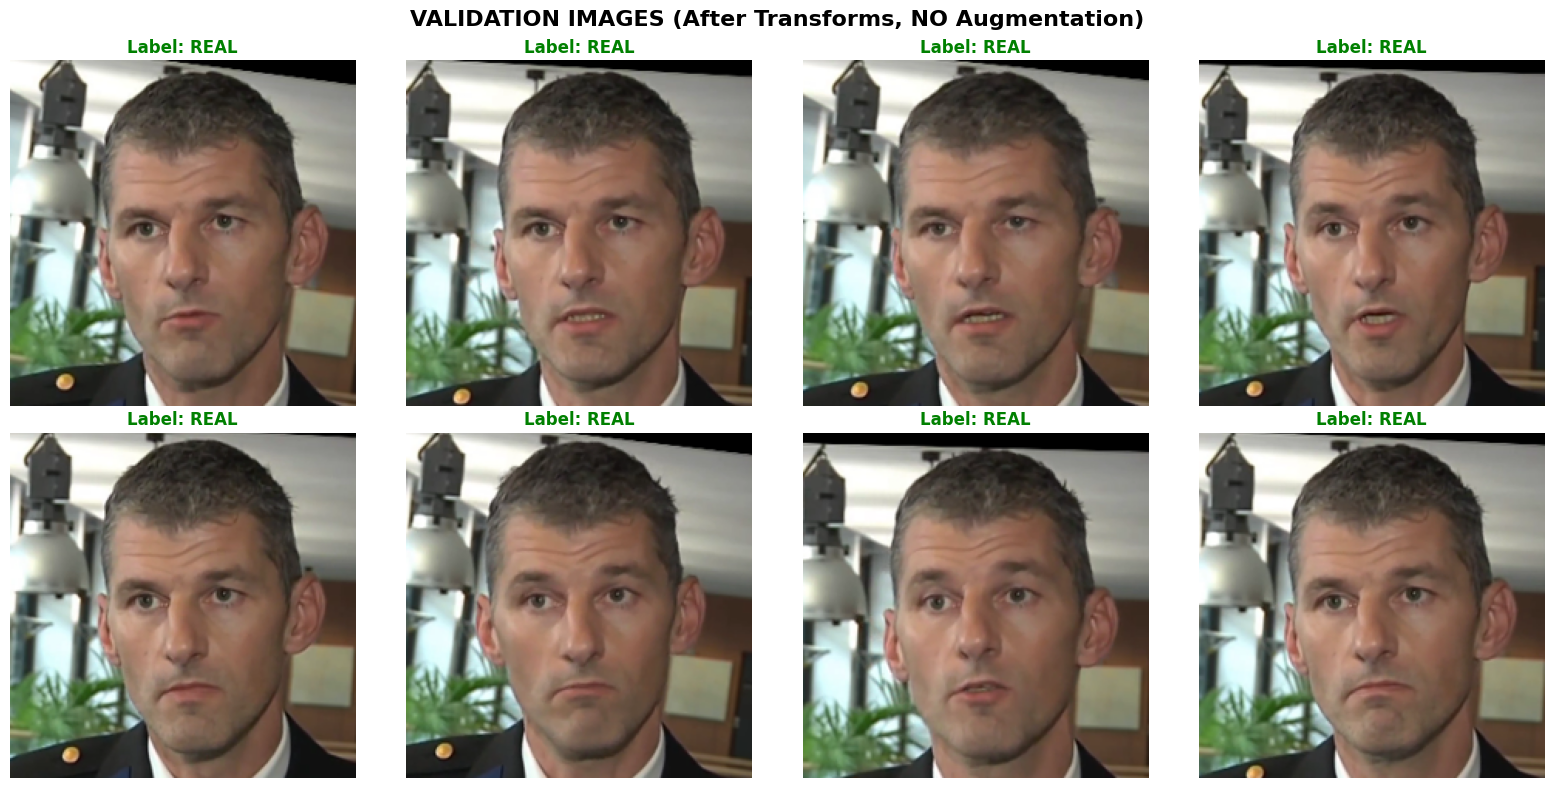


IMAGE STATISTICS
Training batch shape: torch.Size([128, 3, 224, 224])
  - Batch size: 128
  - Channels: 3 (RGB)
  - Height: 224px
  - Width: 224px

Normalized value range: [-1.00, 1.00]
Labels in batch: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
  - Fake (0): 45 images
  - Real (1): 83 images


In [68]:
# Visualize transformed images from DataLoader

import matplotlib.pyplot as plt
import numpy as np
import torch

# Helper function to denormalize images (reverse ImageNet normalization for display)
def denormalize(tensor):
    """Convert normalized tensor back to viewable image"""
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    tensor = tensor * std + mean  # Reverse normalization
    tensor = torch.clamp(tensor, 0, 1)  # Clip to [0, 1]
    return tensor

# Get one batch from train loader
images, labels = next(iter(train_loader))

# Display first 8 images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('TRAINING IMAGES (After Transforms + Augmentation)', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    # Get image and label
    img = images[idx]
    label = labels[idx].item()
    
    # Denormalize for display
    img = denormalize(img)
    
    # Convert from (C, H, W) to (H, W, C) for matplotlib
    img = img.permute(1, 2, 0).numpy()
    
    # Display
    ax.imshow(img)
    ax.set_title(f"Label: {'REAL' if label == 0 else 'FAKE'}",
                 fontsize=12, 
                 color='green' if label == 0 else 'red',
                 fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Get one batch from validation loader
images_val, labels_val = next(iter(val_loader))

# Display first 8 validation images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('VALIDATION IMAGES (After Transforms, NO Augmentation)', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    img = images_val[idx]
    label = labels_val[idx].item()
    
    img = denormalize(img)
    img = img.permute(1, 2, 0).numpy()
    
    ax.imshow(img)
    ax.set_title(f"Label: {'REAL' if label == 0 else 'FAKE'}",
                 fontsize=12, 
                 color='green' if label == 0 else 'red',
                 fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*60}")
print("IMAGE STATISTICS")
print(f"{'='*60}")
print(f"Training batch shape: {images.shape}")
print(f"  - Batch size: {images.shape[0]}")
print(f"  - Channels: {images.shape[1]} (RGB)")
print(f"  - Height: {images.shape[2]}px")
print(f"  - Width: {images.shape[3]}px")
print(f"\nNormalized value range: [{images.min():.2f}, {images.max():.2f}]")
print(f"Labels in batch: {labels.tolist()}")
print(f"  - Fake (0): {(labels == 0).sum().item()} images")
print(f"  - Real (1): {(labels == 1).sum().item()} images")

# Phase 3 : Model Creation

In [69]:
# Load pretrained ResNet50 and modify for binary classification

import torch
import torch.nn as nn
from torchvision import models

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'='*60}")
print(f"DEVICE: {device}")
print(f"{'='*60}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Running on CPU (training will be slower)")

# Load pretrained ResNet50
print(f"\n{'='*60}")
print("LOADING PRETRAINED RESNET50")
print(f"{'='*60}")

model = models.resnet50()  # Download ImageNet weights
print("✅ ResNet50 loaded with ImageNet weights")

# Inspect original final layer
print(f"\nOriginal final layer (classifier):")
print(f"  {model.fc}")
print(f"  - Input features: {model.fc.in_features}")
print(f"  - Output classes: {model.fc.out_features} (ImageNet has 1000 classes)")

# Replace final layer for binary classification
print(f"\n{'='*60}")
print("MODIFYING MODEL FOR BINARY CLASSIFICATION")
print(f"{'='*60}")

num_features = model.fc.in_features  # 2048 for ResNet50
model.fc = nn.Linear(num_features, 2)  # 2 outputs: fake (0) or real (1)

print(f"✅ Final layer replaced:")
print(f"  {model.fc}")
print(f"  - Input features: {model.fc.in_features}")
print(f"  - Output classes: {model.fc.out_features} (0=fake, 1=real)")

# Move model to GPU/CPU
model = model.to(device)
print(f"\n✅ Model moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n{'='*60}")
print("MODEL SUMMARY")
print(f"{'='*60}")
print(f"Architecture: ResNet50")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Pretrained: Yes (ImageNet)")
print(f"Modified: Final layer (1000 → 2 classes)")

# Test forward pass
print(f"\n{'='*60}")
print("TESTING FORWARD PASS")
print(f"{'='*60}")

model.eval()  # Set to evaluation mode
with torch.no_grad():
    # Get a batch from train loader
    test_images, test_labels = next(iter(train_loader))
    test_images = test_images.to(device)
    
    # Forward pass
    outputs = model(test_images)
    
    print(f"✅ Forward pass successful!")
    print(f"  Input shape: {test_images.shape}")
    print(f"  Output shape: {outputs.shape}")
    print(f"  Output (raw logits) for first image: {outputs[0].cpu().numpy()}")
    
    # Apply softmax to get probabilities
    probs = torch.softmax(outputs, dim=1)
    print(f"  Probabilities for first image: {probs[0].cpu().numpy()}")
    print(f"    → Fake: {probs[0][0].item()*100:.1f}%")
    print(f"    → Real: {probs[0][1].item()*100:.1f}%")
    
    # Get predictions
    _, preds = torch.max(outputs, 1)
    print(f"  Prediction: {'REAL' if preds[0].item() == 0 else 'FAKE'}")
    print(f"  Actual label: {'REAL' if test_labels[0].item() == 0 else 'FAKE'}")

print(f"\n{'='*60}")
print("✅ MODEL READY FOR TRAINING!")
print(f"{'='*60}")

DEVICE: cuda
GPU: NVIDIA GeForce RTX 4090
Memory: 25.25 GB

LOADING PRETRAINED RESNET50
✅ ResNet50 loaded with ImageNet weights

Original final layer (classifier):
  Linear(in_features=2048, out_features=1000, bias=True)
  - Input features: 2048
  - Output classes: 1000 (ImageNet has 1000 classes)

MODIFYING MODEL FOR BINARY CLASSIFICATION
✅ Final layer replaced:
  Linear(in_features=2048, out_features=2, bias=True)
  - Input features: 2048
  - Output classes: 2 (0=fake, 1=real)

✅ Model moved to cuda

MODEL SUMMARY
Architecture: ResNet50
Total parameters: 23,512,130
Trainable parameters: 23,512,130
Pretrained: Yes (ImageNet)
Modified: Final layer (1000 → 2 classes)

TESTING FORWARD PASS
✅ Forward pass successful!
  Input shape: torch.Size([128, 3, 224, 224])
  Output shape: torch.Size([128, 2])
  Output (raw logits) for first image: [-10.728538    2.6405017]
  Probabilities for first image: [1.5627850e-06 9.9999845e-01]
    → Fake: 0.0%
    → Real: 100.0%
  Prediction: FAKE
  Actual l

 ## loss function and optimizer

In [70]:
# Define loss function, optimizer, and learning rate scheduler

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
print(f"{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")

# Loss function
# Add class weights to fix prediction bias
class_weights = torch.tensor([1.9, 1.0], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"✓ Using class weights: Fake={1.0}, Real={1.9}")
print(f"Loss function: CrossEntropyLoss")
print(f"  - Used for classification tasks")
print(f"  - Combines softmax + negative log likelihood")
print(f"  - Penalizes confident wrong predictions heavily")

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho: {rho}"
        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
    
    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)
            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = p.grad * scale
                p.add_(e_w)  # 向梯度方向扰动参数
        if zero_grad:
            self.zero_grad()
    
    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]  # 恢复原始参数
        self.base_optimizer.step()  # 更新参数
        if zero_grad:
            self.zero_grad()
    
    def _grad_norm(self):
        norm = torch.norm(
            torch.stack([
                p.grad.norm(p=2)
                for group in self.param_groups for p in group["params"]
                if p.grad is not None
            ]),
            p=2
        )
        return norm

# Optimizer
learning_rate = 0.001  # Starting learning rate
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4  # L2 regularization (prevents overfitting)
)
# optimizer = SAM(model.parameters(), optim.Adam, lr=learning_rate,
#     weight_decay=1e-4)

print(f"\nOptimizer: Adam")
print(f"  - Learning rate: {learning_rate}")
print(f"  - Weight decay: 1e-4 (L2 regularization)")
print(f"  - Parameters to optimize: {len(list(model.parameters()))}")

# Learning rate scheduler (reduce LR when training plateaus)
scheduler = StepLR(
    optimizer,
    step_size=7,    # Reduce LR every 7 epochs
    gamma=0.1       # Multiply LR by 0.1
)

print(f"\nLearning rate scheduler: StepLR")
print(f"  - Step size: 7 epochs")
print(f"  - Gamma: 0.1 (LR × 0.1 every 7 epochs)")
print(f"  - Example: Epoch 0-6: LR=0.001, Epoch 7-13: LR=0.0001")

# Training hyperparameters
num_epochs = 15  # Total training epochs
print(f"\n{'='*60}")
print("HYPERPARAMETERS")
print(f"{'='*60}")
print(f"Epochs: {num_epochs}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Initial learning rate: {learning_rate}")
print(f"Device: {device}")

# Calculate steps per epoch
steps_per_epoch = len(train_loader)
total_steps = num_epochs * steps_per_epoch

print(f"\n{'='*60}")
print("TRAINING PLAN")
print(f"{'='*60}")
print(f"Training images: {len(train_dataset):,}")
print(f"Validation images: {len(val_dataset):,}")
print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total training steps: {total_steps:,}")
print(f"Estimated time: ~{num_epochs * 3}-{num_epochs * 5} minutes (on GPU)")

print(f"\n✅ Training configuration ready!")

TRAINING CONFIGURATION
✓ Using class weights: Fake=1.0, Real=1.9
Loss function: CrossEntropyLoss
  - Used for classification tasks
  - Combines softmax + negative log likelihood
  - Penalizes confident wrong predictions heavily

Optimizer: Adam
  - Learning rate: 0.001
  - Weight decay: 1e-4 (L2 regularization)
  - Parameters to optimize: 161

Learning rate scheduler: StepLR
  - Step size: 7 epochs
  - Gamma: 0.1 (LR × 0.1 every 7 epochs)
  - Example: Epoch 0-6: LR=0.001, Epoch 7-13: LR=0.0001

HYPERPARAMETERS
Epochs: 15
Batch size: 128
Initial learning rate: 0.001
Device: cuda

TRAINING PLAN
Training images: 698
Validation images: 100
Steps per epoch: 698
Total training steps: 10,470
Estimated time: ~45-75 minutes (on GPU)

✅ Training configuration ready!


# train

In [71]:
# MEMORY-OPTIMIZED Training loop

import time
from tqdm import tqdm
import copy
import torch
import gc  # Garbage collector

# Track best model
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print(f"{'='*60}")
print("STARTING TRAINING (Memory-Optimized)")
print(f"{'='*60}\n")

for epoch in range(num_epochs):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.6f}")
    print("-" * 60)
    
    # Clear GPU cache before each epoch
    torch.cuda.empty_cache()
    gc.collect()
    
    # ================== TRAINING PHASE ==================
    model.train()
    
    train_loss = 0.0
    train_corrects = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, (images, labels) in enumerate(train_pbar):
        images = images.to(device)
        labels = labels.to(device)
        b = images.size(0)
        
        # 设置扰动强度
        epsilon = 0.05  # 扰动大小，可以根据需要调整
        
        optimizer.zero_grad()
        
        # # ========== 第一次前向传播：原始输入 ==========
        # images.requires_grad = True
        # outputs = model(images)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # grad = images.grad.data
        # grad_norm = grad.norm(p=2, dim=(1, 2, 3), keepdim=True) + 1e-8  # 防止除零
        # grad_normalized = grad / grad_norm
        # images.requires_grad = False
        # images_perturbed = (images + epsilon * grad_normalized).detach()
        # images_perturbed = torch.clamp(images_perturbed, 0, 1).detach()  # 假设输入在[0,1]范围内
        #
        # train_loss += loss.item() * b
        # _, preds = torch.max(outputs, 1)
        # train_corrects += (preds == labels).sum().item()
        # train_total += labels.size(0)
        # train_pbar.set_postfix({
        #     'loss': f'{loss.item():.4f}'
        # })
        #
        # del images, outputs, grad, grad_norm, grad_normalized
        #
        # # 第二次前向传播（使用更新后的参数）
        # # optimizer.first_step(zero_grad=True)
        # optimizer.zero_grad()
        # outputs = model(images_perturbed)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # # optimizer.second_step(zero_grad=True)
        # optimizer.step()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        # optimizer.second_step(zero_grad=True)
        optimizer.step()

        train_loss += loss.item() * b
        _, preds = torch.max(outputs, 1)
        train_corrects += (preds == labels).sum().item()
        train_total += labels.size(0)
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}'
        })
        
        # Clear memory every 100 batches
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()
        
        # Delete tensors to free memory
        # del labels, outputs, images_perturbed
        # del loss
        # del preds
    
    epoch_train_loss = train_loss / train_total
    epoch_train_acc = train_corrects / train_total
    
    # Clear memory before validation
    torch.cuda.empty_cache()
    gc.collect()
    
    # ================== VALIDATION PHASE ==================
    model.eval()
    
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_pbar):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += (preds == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # Clear memory every 50 batches
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()
            
            del images, labels, outputs, loss, preds
    
    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_corrects / val_total
    
    scheduler.step()
    
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    history['lr'].append(current_lr)
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"✅ New best model! Val Acc: {epoch_val_acc*100:.2f}%")
    
    epoch_time = time.time() - epoch_start
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}%")
    print(f"Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc*100:.2f}%")
    print(f"Time: {epoch_time:.1f}s")
    
    # Print GPU memory usage
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.max_memory_allocated()/1e9:.2f}GB")
        torch.cuda.reset_peak_memory_stats()
    print()

model.load_state_dict(best_model_wts)

print(f"{'='*60}")
print("TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")

# Save model
torch.save(model.state_dict(), '/root/autodl-tmp/DD/weights.pth')
print("kage bunshin no jutsu applied!")
# os.system("/usr/bin/shutdown")

STARTING TRAINING (Memory-Optimized)

Epoch 1/15 | LR: 0.001000
------------------------------------------------------------


KeyboardInterrupt: 

# Evaluation

In [ ]:
# make model in evaluation mode
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

model.load_state_dict(torch.load("/root/autodl-tmp/DD/weights_datap.pth"))
model.eval()

# Evaluate on test set
test_correct = 0
test_total = 0
all_preds = []
all_labels = []
scores = []

print("\nEvaluating on test set...")
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader, desc='Testing')):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        score = outputs.data[..., 1]  # 获取正类（类别1）的分数
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        scores.extend(score.cpu().numpy())
        
        # Clear cache every 100 batches
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()

test_accuracy = 100 * test_correct / test_total

# 确保所有数据都已收集
all_labels = np.array(all_labels)
scores = np.array(scores)

# 计算AUC
try:
    test_auc = roc_auc_score(all_labels, scores)
    print(f"\n{'='*50}")
    print(f"🎯 TEST SET ACCURACY: {test_accuracy:.2f}%")
    print(f"📈 TEST SET AUC: {test_auc:.4f}")
    print(f"{'='*50}")
    print(f"Correct predictions: {test_correct:,} / {test_total:,}")
    
    # 可选：绘制ROC曲线
    fpr, tpr, thresholds = roc_curve(all_labels, scores)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
except ValueError as e:
    print(f"\n⚠️  AUC计算失败: {e}")
    print("可能原因：数据集中只有一个类别（全部是正类或全部是负类）")
    print(f"\n{'='*50}")
    print(f"🎯 TEST SET ACCURACY: {test_accuracy:.2f}%")
    print(f"{'='*50}")
    print(f"Correct predictions: {test_correct:,} / {test_total:,}")

## confusing matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['Fake', 'Real']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix - Test Set\n', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm[i].sum() * 100
        ax.text(j, i-0.2, f'({percentage:.1f}%)', 
                ha='center', va='center', color='darkred', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Fake → Fake):  {cm[0,0]:,} ({cm[0,0]/cm[0].sum()*100:.2f}%)")
print(f"  False Positives (Fake → Real): {cm[0,1]:,} ({cm[0,1]/cm[0].sum()*100:.2f}%)")
print(f"  False Negatives (Real → Fake): {cm[1,0]:,} ({cm[1,0]/cm[1].sum()*100:.2f}%)")
print(f"  True Positives (Real → Real):  {cm[1,1]:,} ({cm[1,1]/cm[1].sum()*100:.2f}%)")

# classification report

In [ ]:
from sklearn.metrics import classification_report

# Generate detailed classification report
print("Classification Report:")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

## visualise prediction

In [ ]:
# Visualize some predictions with confidence scores
def visualize_predictions(dataset, model, device, num_samples=12):
    model.eval()
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for idx, img_idx in enumerate(indices):
            img, label = dataset[img_idx]
            img_tensor = img.unsqueeze(0).to(device)
            
            output = model(img_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            # Convert tensor to displayable image
            img_display = img.permute(1, 2, 0).cpu().numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            # Plot
            axes[idx].imshow(img_display)
            axes[idx].axis('off')
            
            true_label = class_names[label]
            pred_label = class_names[predicted.item()]
            conf = confidence.item() * 100
            
            color = 'green' if label == predicted.item() else 'red'
            title = f"True: {true_label}\nPred: {pred_label} ({conf:.1f}%)"
            axes[idx].set_title(title, fontsize=10, color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.show()

visualize_predictions(test_dataset, model, device, num_samples=12)